## Librarires

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import mean_squared_error,r2_score
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from datetime import date
from sklearn.preprocessing import StandardScaler
import joblib

In [2]:
df = pd.read_csv("NHA_training_data.csv")

In [3]:
df.drop(columns=["Unnamed: 0"],axis=1,inplace=True)
df.fillna(df.median(numeric_only=True),inplace=True)

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
BASICSHIM,80000.0,1.595969,0.193856,1.28,1.43,1.50,1.80,1.99
LHSSHIM,80000.0,1.593807,0.210571,0.88,1.43,1.54,1.78,2.35
RHSSHIM,80000.0,1.585737,0.209810,0.87,1.42,1.53,1.77,2.34


## Outlier replacing with median

0.6188303998927871

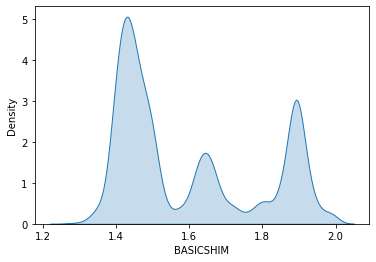

In [5]:
sns.kdeplot(df['BASICSHIM'],fill=True)
df['BASICSHIM'].skew()

0.48463675939398343

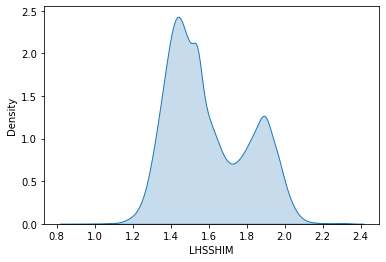

In [6]:
sns.kdeplot(df['LHSSHIM'],fill=True)
df['LHSSHIM'].skew()

0.48226224971070397

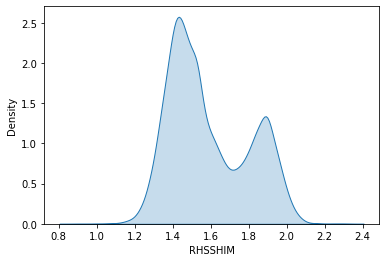

In [7]:
sns.kdeplot(df['RHSSHIM'],fill=True)
df['RHSSHIM'].skew()

In [8]:
selected_features = ["BASICSHIM","LHSSHIM","RHSSHIM"]

for col in selected_features:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    median = df[col].median()
    
    df[col] = np.where((df[col] < lower_bound) | (df[col] > upper_bound), median, df[col])


df

,BASICSHIM,BENCH_NAME,DATE_AND_TIME_LOCAL,DATE_AND_TIME,LHSSHIM,RHSSHIM,SHIMTYPE,TYPE
0,1.68,Line 2 PS1,2025-04-04T12:15:27.387,Apr 4 2025 12:15PM,1.65,1.55,2430 100 976,240+8
1,1.40,Line 2 PS1,2025-05-02T13:17:40.227,May 2 2025 1:17PM,1.48,1.49,2430 100 976,250+8=020
2,1.43,Line 2 PS1,2025-05-07T07:58:42.763,May 7 2025 7:58AM,1.43,1.40,2430 100 976,250+8=020
3,1.84,Line 2 PS1,2025-06-06T06:23:21.787,Jun 6 2025 6:23AM,1.81,1.85,2430 100 976,260+8
4,1.45,Line 2 PS1,2025-03-17T13:21:07.027,Mar 17 2025 1:21PM,1.64,1.40,2430 100 976,250+8=020
...,...,...,...,...,...,...,...,...
79995,1.91,Line 2 PS1,2025-06-12T15:07:08.117,Jun 12 2025 3:07PM,1.77,1.91,2430 100 976,250+10
79996,1.42,Line 2 PS1,2025-04-25T14:17:35.057,Apr 25 2025 2:17PM,1.44,1.46,2430 100 976,250+8=020
79997,1.75,Line 2 PS1,2025-04-03T06:29:12.800,Apr 3 2025 6:29AM,1.64,1.53,2430 100 976,250+8=020
79998,1.40,Line 2 PS1,2025-06-18T13:24:19.610,Jun 18 2025 1:24PM,1.41,1.44,2430 100 976,250+8=020


In [9]:
# df['BASICSHIM_log'] = np.log(df['BASICSHIM'] + 1) 
# df['LHSSHIM_log'] = np.log(df['LHSSHIM'] + 1)  
# df['RHSSHIM_log'] = np.log(df['RHSSHIM'] + 1)  

0.6188303998927871

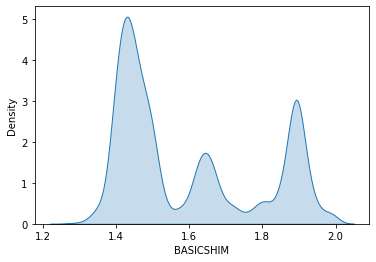

In [10]:
sns.kdeplot(df['BASICSHIM'],fill=True)
df['BASICSHIM'].skew()

0.47838692369237035

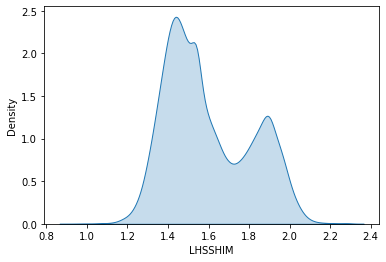

In [11]:
sns.kdeplot(df['LHSSHIM'],fill=True)
df['LHSSHIM'].skew()

0.4807124329715648

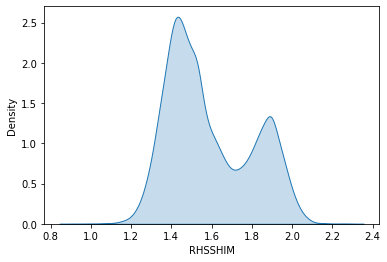

In [12]:
sns.kdeplot(df['RHSSHIM'],fill=True)
df['RHSSHIM'].skew()

## Feature selection 

In [13]:
X = df[["LHSSHIM","RHSSHIM","TYPE"]].copy()
X['TYPE'] = X['TYPE'].astype('category')

y = df["BASICSHIM"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

## Testing dataset loading 

In [14]:
tdf = pd.read_csv("NHA_test_data.csv")

In [15]:
X1 = tdf[["LHSSHIM","RHSSHIM","TYPE"]].copy()
X1['TYPE'] = X1['TYPE'].astype('category')
y1 = tdf['BASICSHIM']
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=143)

## CatBoostingRegressor Modeling 

In [16]:
# cmodel = CatBoostRegressor(iterations = 200,
#                            max_depth = 8,
#                            learning_rate = 0.05,
#                            subsample = 1.0,
#                            verbose=0,
#                            loss_function="RMSE",
#                            random_state=42)

# cmodel.fit(X_train, y_train, cat_features=['TYPE'])
# y_pred = cmodel.predict(X_test)

# mse = mean_squared_error(y_test,y_pred)
# rmse = np.sqrt(mse)
# r2_scores = r2_score(y_test,y_pred)

# print(f"Mean Squared Error -> {mse*100:.2f}%")
# print(f"Root Mean Square Error -> {rmse:.2f}%")
# print(f"R2 Score -> {r2_scores*100:.2f}%")

## LightBoostRegressor Modeling

In [17]:
final_lmodel = LGBMRegressor(
    subsample=1.0,
    max_depth=6,
    n_estimators=200,
    learning_rate=0.05,
    verbose=-1,
    n_jobs=-1,
    colsample_bytree=1.0,
    random_state=123
)

final_lmodel.fit(X_train, y_train)
y_predictions = final_lmodel.predict(X_test)

mse = mean_squared_error(y_test, y_predictions)
rmse = np.sqrt(mse)
r2_scores = r2_score(y_test, y_predictions)
mean_r2 = r2_score(y_test, y_predictions, multioutput='uniform_average')

print(f"Mean Squared Error -> {mse:.4f}mm²")
print(f"Root Mean Square Error -> {rmse:.4f}mm²")
print(f"R2 Score -> {r2_scores*100:.2f}%")
print(f"Mean R2 Score -> {mean_r2*100:.2f}%")

Mean Squared Error -> 0.0037mm²
Root Mean Square Error -> 0.0607mm²
R2 Score -> 90.23%
Mean R2 Score -> 90.23%


## Testing The Training Data

In [18]:
print("X_train shape:", X_train.shape)
print("X1_train shape:", X1_train.shape)

print("X_train columns:", X_train.columns)
print("X1_train columns:", X1_train.columns)


X_train shape: (64000, 3)
X1_train shape: (16000, 3)
X_train columns: Index(['LHSSHIM', 'RHSSHIM', 'TYPE'], dtype='object')
X1_train columns: Index(['LHSSHIM', 'RHSSHIM', 'TYPE'], dtype='object')


In [19]:
y1_train_pred = final_lmodel.predict(X1_train)

r2_train = r2_score(y1_train, y1_train_pred)
mse_train = mean_squared_error(y1_train, y1_train_pred)
print(f"Training R²: {r2_train*100:.2f}% | MSE: {mse_train:.4f}mm^2")


Training R²: 90.30% | MSE: 0.0037mm^2


## Testing The Test Data

In [20]:
y1_test_pred = final_lmodel.predict(X1_test)

r2_test = r2_score(y1_test, y1_test_pred)
mse_test = mean_squared_error(y1_test, y1_test_pred)
print(f"Test R²: {r2_test*100:.2f}% | MSE: {mse_test:.4f}")


Test R²: 90.65% | MSE: 0.0036


In [21]:
# joblib.dump(final_lmodel,"lgbm.pkl")

## Real time value prediction

In [22]:
from datetime import date
import pandas as pd


sample = [[1.63, 1.61, "240+8"]]
sample_df = pd.DataFrame(sample, columns=["LHSSHIM", "RHSSHIM", "TYPE"])

sample_df["TYPE"] = sample_df["TYPE"].astype("category")  

actual_value = 1.629
pred = final_lmodel.predict(sample_df)

dic = {
    "date": date.today(),
    "Actual":actual_value,
    "Predicted": pred[0]
}

result_df = pd.DataFrame([dic])
result_df


,date,Actual,Predicted
0,2025-07-14,1.629,1.640614


In [23]:
Mean_Absolute_Error = abs(actual_value - pred)
print(f"MAE -> {Mean_Absolute_Error}")

MAE -> [0.01161385]


In [24]:
df

,BASICSHIM,BENCH_NAME,DATE_AND_TIME_LOCAL,DATE_AND_TIME,LHSSHIM,RHSSHIM,SHIMTYPE,TYPE
0,1.68,Line 2 PS1,2025-04-04T12:15:27.387,Apr 4 2025 12:15PM,1.65,1.55,2430 100 976,240+8
1,1.40,Line 2 PS1,2025-05-02T13:17:40.227,May 2 2025 1:17PM,1.48,1.49,2430 100 976,250+8=020
2,1.43,Line 2 PS1,2025-05-07T07:58:42.763,May 7 2025 7:58AM,1.43,1.40,2430 100 976,250+8=020
3,1.84,Line 2 PS1,2025-06-06T06:23:21.787,Jun 6 2025 6:23AM,1.81,1.85,2430 100 976,260+8
4,1.45,Line 2 PS1,2025-03-17T13:21:07.027,Mar 17 2025 1:21PM,1.64,1.40,2430 100 976,250+8=020
...,...,...,...,...,...,...,...,...
79995,1.91,Line 2 PS1,2025-06-12T15:07:08.117,Jun 12 2025 3:07PM,1.77,1.91,2430 100 976,250+10
79996,1.42,Line 2 PS1,2025-04-25T14:17:35.057,Apr 25 2025 2:17PM,1.44,1.46,2430 100 976,250+8=020
79997,1.75,Line 2 PS1,2025-04-03T06:29:12.800,Apr 3 2025 6:29AM,1.64,1.53,2430 100 976,250+8=020
79998,1.40,Line 2 PS1,2025-06-18T13:24:19.610,Jun 18 2025 1:24PM,1.41,1.44,2430 100 976,250+8=020


In [25]:
df['TYPE'].unique()

array(['240+8', '250+8=020', '260+8', '250+10', '250+8=028',
       '250+10(028)', '230+8=020', '260+10=020', '270+8', '250+8',
       '245+10', '275+8=020', 'Master 300', '258+8=020', '255+10',
       '255+8', '255+8=020', '200+8(028)', '280+8', '255+8=028'],
      dtype=object)